#### inferCNV Benchmarking Code

In [4]:
!pip install infercnvpy
!pip install git+https://github.com/nik548/cscbfinalprojectS25.git

  Cloning https://github.com/nik548/cscbfinalprojectS25.git to /tmp/pip-req-build-ka53m8g7
  Running command git clone --filter=blob:none --quiet https://github.com/nik548/cscbfinalprojectS25.git /tmp/pip-req-build-ka53m8g7
  Resolved https://github.com/nik548/cscbfinalprojectS25.git to commit f19f6602d4bcc3dd15285ba2e6ffa85e1ddb340e
  Preparing metadata (setup.py) ... done


In [11]:
import re
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as ic  # new import for inferCNVpy
from scipy.sparse import csr_matrix, issparse
from typing import List, Dict, Tuple, Optional, Sequence
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import genecnv as genecnv
from genecnv import run_adaptive_cnv_pipeline, annotate_cnv_calls, annotate_genes_mygene, preprocess, make_adaptive_bins, bin_expression_matrix, log_decay_smoothing
import anndata as ad

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Load or create an AnnData object (adata)
adata = ad.read_h5ad("/content/drive/MyDrive/CSCB_Final/Data/PBMC_simulated_cnas_041025.h5ad")

# (Optional) Clean data
allowed = [str(i) for i in range(1,23)] + ['X','Y']
adata_clean = preprocess(adata, allowed_chromosomes = allowed)

[QC] Filtered to 10259 cells
[QC] Retained 19769 genes after min_cells_per_gene=3
[QC] Retained 19179 genes with genomic coords
[Norm] Scaled to 10000.0 counts per cell
[Norm] Applied log1p
[Preprocess] Completed: 10259 cells × 19179 genes


In [18]:
def run_infercnvpy_tl(
    adata: sc.AnnData,
    reference_key: str = 'is_ref',
    reference_cat: Optional[Sequence[str]] = [True],
    lfc_clip: float = 3.0,
    window_size: int = 100,
    step: int = 10,
    dynamic_threshold: float = 1.5,
    exclude_chromosomes: Tuple[str,...] = None,
    chunksize: int = 5000,
    n_jobs: Optional[int] = None,
    layer: Optional[str] = None,
    key_added: str = 'cnv',
    calculate_gene_values: bool = False
) -> None:
    """
    Run infercnvpy.tl.infercnv on adata, storing results in adata.obsm and adata.uns.

    reference_cat: one or list of obs[reference_key] values to use as normal. If None uses all cells.
    """
    ic.tl.infercnv(
        adata,
        reference_key=reference_key,
        reference_cat=reference_cat,
        reference=None,
        lfc_clip=lfc_clip,
        window_size=window_size,
        step=step,
        dynamic_threshold=dynamic_threshold,
        exclude_chromosomes=exclude_chromosomes,
        chunksize=chunksize,
        n_jobs=n_jobs,
        inplace=True,
        layer=layer,
        key_added=key_added,
        calculate_gene_values=calculate_gene_values
    )
    print(f"infercnvpy: results stored in adata.obsm['X_{key_added}'] and adata.uns['{key_added}'].")

In [19]:
def get_reference_indices(
    adata: sc.AnnData,
    cell_type_key: Optional[str] = None,
    target_genes_per_bin: int = 100,
    decay_scale: float = 1e6,
    decay_radius: Optional[int] = 10,
    reference_frac: float = 0.15
) -> np.ndarray:
    """
    Return the integer indices of the lowest‑variance cells per cell‐type,
    exactly as used in reference_center, without running the HMM.

    Parameters
    ----------
    adata
        Preprocessed AnnData.
    cell_type_key
        obs column for cell‐type stratification (or None for all cells together).
    target_genes_per_bin, decay_scale, decay_radius
        must match what you will later feed into run_adaptive_cnv_pipeline.
    reference_frac
        fraction of lowest‐variance cells per type to select.

    Returns
    -------
    ref_idx
        1D array of cell‐indices into `adata` to use as diploid reference.
    """
    # 1) build adaptive bins
    bins = make_adaptive_bins(adata, target_genes_per_bin)

    # 2) compute raw bin expression (cells × bins)
    B = bin_expression_matrix(adata, bins)

    # 3) smooth (this step is cheap: B.dot(W.T))
    centers = np.array([
        (adata.var.loc[bg,'start'].min() + adata.var.loc[bg,'end'].max())/2
        for bg in bins
    ])
    S = log_decay_smoothing(B, centers, decay_scale, decay_radius)

    # 4) within each cell‐type, compute per‐cell variance and pick lowest‐variance
    cell_types = (
        adata.obs[cell_type_key].astype(str).tolist()
        if cell_type_key else
        ['all'] * adata.n_obs
    )
    ref_idx = []
    for ct in np.unique(cell_types):
        ids = np.where(np.array(cell_types) == ct)[0]
        var = S[ids].var(axis=1)
        n_ref = max(int(len(ids) * reference_frac), 1)
        ref_ct = ids[np.argsort(var)[:n_ref]]
        ref_idx.append(ref_ct)
    return np.concatenate(ref_idx).astype(int)


def fast_add_reference_key(
    adata: sc.AnnData,
    cell_type_key: Optional[str] = None,
    **ref_kwargs
) -> None:
    """
    Add adata.obs['is_ref'] by selecting lowest‐variance cells via get_reference_indices.
    All other cells are marked False.
    """
    ref_idx = get_reference_indices(adata, cell_type_key=cell_type_key, **ref_kwargs)
    mask = np.zeros(adata.n_obs, bool)
    mask[ref_idx] = True
    adata.obs['is_ref'] = mask
    print(f"Marked {mask.sum()}/{adata.n_obs} cells as reference.")


In [21]:
# 1) Add reference cells (as required by infer_cnv)
fast_add_reference_key(
    adata_clean,
    cell_type_key='cell_type',
    target_genes_per_bin=100,
    decay_scale=1e6,
    decay_radius=10,
    reference_frac=0.15
)

Marked 1535/10259 cells as reference.


In [25]:
# normalize once, only prefix if needed
adata_clean.var['chromosome'] = (
    adata_clean.var['chromosome']
    .astype(str)
    .map(lambda x: x if x.startswith("chr") else f"chr{x}")
)

In [26]:
adata_clean.var

,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,chromosome,start,end,strand
original_index,,,,,,,,,,,,,,
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,4,0.000388,99.961199,4.0,4,chr1,89551.0,91105.0,-1.0
AL669831.5,ENSG00000237491,Gene Expression,GRCh38,False,False,597,0.062276,94.208944,642.0,597,chr1,778739.0,810066.0,1.0
FAM87B,ENSG00000177757,Gene Expression,GRCh38,False,False,11,0.001164,99.893297,12.0,11,chr1,817363.0,819842.0,1.0
LINC00115,ENSG00000225880,Gene Expression,GRCh38,False,False,300,0.030653,97.089921,316.0,300,chr1,586945.0,827989.0,-1.0
FAM41C,ENSG00000230368,Gene Expression,GRCh38,False,False,276,0.027355,97.322728,282.0,276,chr1,868052.0,877032.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C21orf58,ENSG00000160298,Gene Expression,GRCh38,False,False,209,0.022990,97.972645,237.0,208,chr21,46300181.0,46323875.0,-1.0
PCNT,ENSG00000160299,Gene Expression,GRCh38,False,False,971,0.106218,90.581046,1095.0,967,chr21,46324124.0,46445769.0,1.0
DIP2A,ENSG00000160305,Gene Expression,GRCh38,False,False,2523,0.320400,75.526239,3303.0,2507,chr21,46458891.0,46572743.0,1.0


In [27]:
def compute_metrics(
    adata: sc.AnnData,
    gt_col: str,
    pred_col: str,
    overlap_fraction: float = 0.5
) -> pd.DataFrame:
    """
    Compute cell‑level confusion metrics by matching predicted vs. ground‑truth CNV regions,
    and return them as a 1‑row pandas DataFrame.

    Parameters
    ----------
    adata
        AnnData with CNV region strings in obs[gt_col] and obs[pred_col].
    gt_col, pred_col : str
        Column names in adata.obs for ground‑truth and predicted region annotations.
    overlap_fraction : float
        Minimum fraction of a ground‑truth segment that must be overlapped by a prediction
        (on the same chromosome) to count as a true positive.

    Returns
    -------
    pd.DataFrame
        One‑row table with columns [accuracy, precision, recall, specificity, TP, TN, FP, FN].
    """
    pattern = re.compile(r"([0-9XY]+):([0-9,]+)-([0-9,]+)")
    def parse(txt):
        out = []
        for m in pattern.finditer(txt or ""):
            chrom, s, e = m.groups()
            out.append((chrom, int(s.replace(",","")), int(e.replace(",",""))))
        return out

    TP = TN = FP = FN = 0
    for cell in adata.obs_names:
        gt = parse(adata.obs.at[cell, gt_col] or "")
        pr = parse(adata.obs.at[cell, pred_col] or "")
        pred_pos = len(pr) > 0
        truth_pos = True

        # require every GT interval to find a matching PR interval
        for cg, sg, eg in gt:
            matched = False
            length = eg - sg
            if length <= 0:
                truth_pos = False
                break
            for cp, sp, ep in pr:
                if cp != cg:
                    continue
                overlap = max(0, min(ep, eg) - max(sp, sg))
                if overlap / length >= overlap_fraction:
                    matched = True
                    break
            if not matched:
                truth_pos = False
                break

        if truth_pos and pred_pos:
            TP += 1
        elif not truth_pos and not pred_pos:
            TN += 1
        elif not truth_pos and pred_pos:
            FP += 1
        elif truth_pos and not pred_pos:
            FN += 1

    total = TP + TN + FP + FN
    acc = (TP + TN) / total if total else np.nan
    prec = TP / (TP + FP) if (TP + FP) else 0.0
    rec = TP / (TP + FN) if (TP + FN) else 0.0
    spec = TN / (TN + FP) if (TN + FP) else 0.0

    # return as a table
    return pd.DataFrame([{
        'accuracy':    acc,
        'precision':   prec,
        'recall':      rec,
        'specificity': spec,
        'TP':          TP,
        'TN':          TN,
        'FP':          FP,
        'FN':          FN
    }])



In [41]:
# 1) Run infercnvpy on your cleaned AnnData (must have adata.obs['is_ref'] set)
run_infercnvpy_tl(
    adata_clean,
    reference_key='is_ref',
    reference_cat=[True],
    lfc_clip=3.0,
    window_size=100,
    step=10,
    dynamic_threshold=1.5,
    exclude_chromosomes=(),   # <-- empty, not None
    chunksize=5000,
    n_jobs=4,
    key_added='cnv',
    calculate_gene_values=False
)

  0%|          | 0/3 [00:00<?, ?it/s]

infercnvpy: results stored in adata.obsm['X_cnv'] and adata.uns['cnv'].


In [47]:
def annotate_selected_cnv_calls(
    adata: sc.AnnData,
    calls: np.ndarray
) -> None:
    """
    From an infercnvpy-style calls array (cells × windows), keep only:
      +1 on chr X → CN4
      -1 on chr 6 → CN1
      -1 on chr 22 → CN0

    Writes textual annotations into adata.obs['cnv_regions'].
    """
    import numpy as np

    # 1) get the chromosome→start‐column mapping
    chr_pos = adata.uns['cnv']['chr_pos']  # e.g. {'chr1':0, 'chr2':151, ...}

    # 2) sort chromosomes by start index
    items = sorted(chr_pos.items(), key=lambda x: x[1])
    chroms, starts = zip(*items)
    # compute end indices (the next chrom's start, or the total #windows)
    ends = list(starts[1:]) + [calls.shape[1]]

    # 3) build a list of (window_idx → chromosome) of length calls.shape[1]
    win2chrom = [None] * calls.shape[1]
    for chrom, st, en in zip(chroms, starts, ends):
        # strip any "chr" prefix for matching your map
        short = chrom.replace("chr", "")
        for j in range(st, en):
            win2chrom[j] = short

    # 4) the special CN mapping
    cn_map = {
        (+1, "X"): 4,
        (-1, "6"): 1,
        (-1, "22"):0,
    }

    regions = []
    for i in range(calls.shape[0]):
        recs = []
        # for each window that has a call
        for j, state in enumerate(calls[i]):
            if state == 0:
                continue
            chrom = win2chrom[j]
            key = (int(state), chrom)
            if key not in cn_map:
                continue
            cn = cn_map[key]

            # **compute genomic span for this window**:
            # approximate by taking the min/max of all genes in that window.
            # get the var rows for genes on this chrom, sorted by start:
            mask = adata.var['chromosome'].astype(str).str.replace("chr","") == chrom
            df = adata.var.loc[mask].sort_values('start')
            # figure out which slice of these genes corresponds to window j:
            # we split them into equal chunks based on number of windows per chrom:
            n_genes = df.shape[0]
            n_wins  = ends[chroms.index("chr"+chrom)] - starts[chroms.index("chr"+chrom)]
            # integer‐division slice:
            genes_per_win = max(n_genes // n_wins, 1)
            idx_in_chrom = j - starts[chroms.index("chr"+chrom)]
            sub = df.iloc[
                idx_in_chrom*genes_per_win : (idx_in_chrom+1)*genes_per_win
            ]
            start_pos = int(sub['start'].min())
            end_pos   = int(sub['end'].max())

            recs.append(f"{chrom}:{start_pos:,}-{end_pos:,} (CN {cn})")

        regions.append(", ".join(recs))

    adata.obs['cnv_regions'] = regions


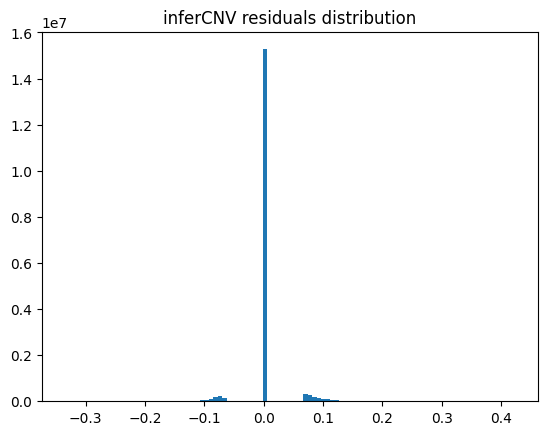

,gains,losses
chromosome,,
chr1,68203,24328
chr2,25607,6971
chr3,13573,4167
chr4,10212,1930
chr5,18519,5857
chr6,20019,3389
chr7,19834,6336
chr8,6965,3116
chr9,9322,2342


call counts: {-1: 104636, 0: 16942313, 1: 383092}
Cells with ≥1 gain: 10259/10259
Cells with ≥1 loss: 9146/10259
Cells with any call: 10259/10259


,cnv_regions
AAACCCAAGCGCCCAT-1,
AAACCCAAGGTTCCGC-1,
AAACCCACAGAGTTGG-1,"6:30,326,479-31,167,159 (CN 1), 6:31,185,197-3..."
AAACCCACAGGTATGG-1,
AAACCCACATAGTCAC-1,
...,...
TTTGTTGGTGCGTCGT-1,"X:101,393,273-102,516,739 (CN 4), X:102,599,16..."
TTTGTTGGTGTCATGT-1,
TTTGTTGGTTTGAACC-1,
TTTGTTGTCCAAGCCG-1,


In [61]:
# 1. Grab inferCNV residuals and ensure a NumPy array
resid = adata_clean.obsm["X_cnv"]
if not isinstance(resid, np.ndarray):
    try:
        resid = resid.toarray()
    except AttributeError:
        resid = np.asarray(resid)

# 3. Threshold into discrete calls: +1=gain, -1=loss, 0=neutral
thr_pos, thr_neg = 0.1, -0.1 # These were the best thresholds after testing range from +/- 0.05-0.3
calls = np.where(resid >= thr_pos,  1,
         np.where(resid <= thr_neg, -1, 0))
adata_clean.obsm['cnv_calls'] = calls

# 4. Build a per‐chromosome summary of gains vs losses
#    infercnvpy stored window starts in uns['cnv']['chr_pos']
chr_pos = adata_clean.uns['cnv']['chr_pos']
# sort chromosomes by their start index
chrom_items = sorted(chr_pos.items(), key=lambda x: x[1])
chrom_names, chrom_starts = zip(*chrom_items)
# determine where each chromosome ends
n_windows = calls.shape[1]
chrom_ends = list(chrom_starts[1:]) + [n_windows]

records = []
for chrom, start, end in zip(chrom_names, chrom_starts, chrom_ends):
    sub = calls[:, start:end]
    records.append({
        'chromosome': chrom,
        'gains':      int((sub ==  1).sum()),
        'losses':     int((sub == -1).sum())
    })

df = pd.DataFrame(records).set_index('chromosome')
display(df)

# 5. Quick overview of overall call counts and how many cells are called
uniq, cnt = np.unique(calls, return_counts=True)
print("Total call counts:", dict(zip(uniq, cnt)))
print(f"Cells with ≥1 gain:  {np.any(calls==1,axis=1).sum()}/{calls.shape[0]}")
print(f"Cells with ≥1 loss:  {np.any(calls==-1,axis=1).sum()}/{calls.shape[0]}")
print(f"Cells with any call: {np.any(calls!=0,axis=1).sum()}/{calls.shape[0]}")

# 6. Annotate only the special-case CNAs into adata.obs['cnv_regions']
annotate_selected_cnv_calls(adata_clean, calls)
display(adata_clean.obs['cnv_regions'])

,accuracy,precision,recall,specificity,TP,TN,FP,FN
0,0.474608,0.617748,0.371397,0.637437,2332,2537,1443,3947


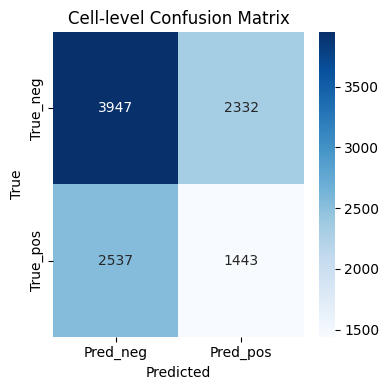

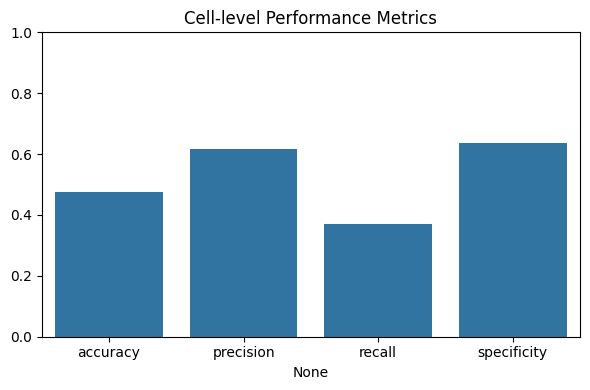

In [62]:
# Compute cell‐level metrics
df_metrics = compute_metrics(
    adata_clean,
    gt_col='simulated_cnvs',
    pred_col='cnv_regions',
    overlap_fraction=0.5
)
display(df_metrics)


# Plot confusion matrix at cell level
y_true = adata_clean.obs['simulated_cnvs'].fillna("").map(lambda s: len(s)>0).values
y_pred = adata_clean.obs['cnv_regions'].fillna("").map(lambda s: len(s)>0).values

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Pred_neg','Pred_pos'],
    yticklabels=['True_neg','True_pos']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Cell‐level Confusion Matrix')
plt.tight_layout()
plt.show()

# Bar‐plot of performance metrics
metrics = df_metrics.iloc[0][['accuracy','precision','recall','specificity']]
plt.figure(figsize=(6,4))
sns.barplot(x=metrics.index, y=metrics.values)
plt.ylim(0,1)
plt.title('Cell‐level Performance Metrics')
plt.tight_layout()
plt.show()